<a href="https://colab.research.google.com/github/arthurreys/feulgen-nuclei-detection/blob/main/notebooks/YOLO_Detec%C3%A7%C3%A3o_Objetos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecção e Classificação de núcleos celulares com coloração de Feulgen, utilizando detecção de objetos com YOLOv8

- 1. Conversão das anotações para formato YOLO

- 2. Fine-tuning YOLOv8

- 3. Visualização de predições

- 4. Extração de métricas


In [ ]:
!pip install -q ultralytics
!pip install -q pycocotools

In [ ]:
!wget -O OD_SS.zip https://arquivos.ufsc.br/f/981acdaa6d2442f68c1a/?dl=1
!unzip OD_SS.zip

--2023-11-28 00:21:55--  https://arquivos.ufsc.br/f/981acdaa6d2442f68c1a/?dl=1
Resolving arquivos.ufsc.br (arquivos.ufsc.br)... 150.162.242.122
Connecting to arquivos.ufsc.br (arquivos.ufsc.br)|150.162.242.122|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://arquivos.ufsc.br/seafhttp/files/11dd61a1-766d-484f-879d-1fd7ceb20b44/1_OD_SS.zip [following]
--2023-11-28 00:21:56--  https://arquivos.ufsc.br/seafhttp/files/11dd61a1-766d-484f-879d-1fd7ceb20b44/1_OD_SS.zip
Reusing existing connection to arquivos.ufsc.br:443.
HTTP request sent, awaiting response... 200 OK
Length: 3270015790 (3.0G) [application/zip]
Saving to: ‘OD_SS.zip’

OD_SS.zip           100%[===================>]   3.04G  19.7MB/s    in 3m 28s  

2023-11-28 00:25:25 (15.0 MB/s) - ‘OD_SS.zip’ saved [3270015790/3270015790]



# Conversão labels do dataset para formato YOLO

In [ ]:
CATEGORIES_DICT = {
    'alterada':0,
    "intermediaria":1,
    "velhas":2,
    "sujeira":3,
    "sobreposicao":4,
    "nao_identificado":5,
    "neutrofilo":6,
    "mancha":7,
}

In [ ]:
DIR = "/content/OD"

In [ ]:
!mkdir -p /content/OD/train/images
!mkdir -p /content/OD/val/images
!mkdir -p /content/OD/test/images

!mkdir -p /content/OD/train/labels
!mkdir -p /content/OD/val/labels
!mkdir -p /content/OD/test/labels

!cp -r /content/OD_SS/train/Images/* /content/OD/train/images
!cp -r /content/OD_SS/val/Images/* /content/OD/val/images
!cp -r /content/OD_SS/test/Images/* /content/OD/test/images

!mkdir -p predictions

In [ ]:
import os
import yaml
import cv2
import json
import io
import base64
import fnmatch
import itertools
import PIL
import csv
import sys
import numpy as np
from google.colab.patches import cv2_imshow
from tqdm import tqdm

from PIL import Image

from matplotlib import pyplot as plt

from ultralytics import YOLO

In [ ]:
def get_data_dicts(base_path, folder, dest_base):

    img_dir = os.path.join(base_path, folder, "Images")
    labels_dir = os.path.join(base_path, folder, "OD_Labels")

    list_of_files = sorted(os.listdir(img_dir))
    dataset_dicts = []

    for idx, item in tqdm(enumerate(list_of_files), total= len(list_of_files)):

        height, width = cv2.imread(os.path.join(img_dir, item)).shape[:2]

        record = {}
        record["file_name"] = os.path.join(img_dir, item)
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        objs = []

        with open(os.path.join(labels_dir, item.replace("png", "txt"))) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')

            data_yolo = []

            for bbox in csv_reader:
                startX, startY, box_width, box_height, label = int(bbox[0].strip()), int(bbox[1].strip()), int(bbox[2].strip()), int(bbox[3].strip()), bbox[4].strip()

                if label == "alterada":
                    category_id = 0
                elif label == "intermediaria":
                    category_id = 1
                elif label == "velhas":
                    category_id = 2
                elif label == "sujeira":
                    category_id = 3
                elif label == "sobreposicao":
                    category_id = 4
                elif label == "nao_identificado":
                    category_id = 5
                elif label == "neutrofilo":
                    category_id = 6
                elif label == "mancha":
                    category_id = 7
                else:
                    print("Erro: classe inválida!")
                    sys.exit(0)

                # Converte para anotação YOLO
                data_yolo.append(
                    f"{category_id} {(startX + box_width/2)/width} {(startY + box_height/2)/height} {box_width/width} {box_height/height}\n"
                )

            with open(os.path.join(dest_base, folder, 'labels', item.replace("png", "txt")), 'w') as text_file:
                for box in data_yolo:
                    text_file.write(box)

    return dataset_dicts


In [ ]:
for subsets in ['train', 'val', 'test']:
  get_data_dicts('OD_SS', subsets, DIR)

100%|██████████| 195/195 [00:10<00:00, 19.29it/s]


# Treinamento do modelo

In [ ]:
labels_map = {
    0: "alterada",
    1: "intermediaria",
    2: "velhas",
    3: "sujeira",
    4: "sobreposicao",
    5: "nao_identificado",
    6: "neutrofilo",
    7: "mancha",
}

In [ ]:
# Criar arquivo de configuração do YOLO

data = dict(
    path ='/content/',
    train = f'{DIR}/train',
    val = f'{DIR}/test',
    names = labels_map
)

with open('config.yaml', 'w') as outfile:
    yaml.dump(data, outfile)

In [ ]:
model = YOLO('yolov8n.pt')

model.train(data='config.yaml', epochs=30)

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=config.yaml, epochs=30, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=Fa

train: Scanning /content/OD/train/labels.cache... 1565 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1565/1565 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/OD/test/labels.cache... 195 images, 0 backgrounds, 0 corrupt: 100%|██████████| 195/195 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      3.05G      1.296      2.871     0.9685        198        640: 100%|██████████| 98/98 [01:40<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.09s/it]

                   all        195       2537      0.375       0.28      0.287      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      3.11G      1.089       1.75     0.9066        287        640: 100%|██████████| 98/98 [01:35<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.06it/s]


                   all        195       2537      0.347      0.485      0.377       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      3.73G      1.047      1.574     0.9028        166        640: 100%|██████████| 98/98 [01:34<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]

                   all        195       2537      0.414      0.498      0.433      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.41G      1.014      1.506     0.9014        170        640: 100%|██████████| 98/98 [01:36<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.13it/s]


                   all        195       2537      0.405      0.478      0.398       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      3.84G      1.001      1.452      0.895        228        640: 100%|██████████| 98/98 [01:37<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.08it/s]

                   all        195       2537       0.52      0.575      0.529      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      3.35G     0.9792       1.36     0.8904        189        640: 100%|██████████| 98/98 [01:36<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.03s/it]


                   all        195       2537      0.465        0.6      0.521      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      3.39G     0.9572      1.316     0.8848        229        640: 100%|██████████| 98/98 [01:37<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.02s/it]


                   all        195       2537      0.462       0.55      0.484      0.354

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30       3.3G     0.9467      1.294     0.8879        328        640: 100%|██████████| 98/98 [01:41<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.30s/it]

                   all        195       2537      0.516      0.568      0.549      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      3.41G     0.9323      1.274     0.8816        324        640: 100%|██████████| 98/98 [01:39<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.17it/s]


                   all        195       2537      0.528      0.566      0.554      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      3.93G     0.9377      1.242       0.88        281        640: 100%|██████████| 98/98 [01:40<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.07it/s]

                   all        195       2537      0.548      0.558      0.564      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.96G     0.9222      1.204     0.8785        311        640: 100%|██████████| 98/98 [01:37<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.18s/it]

                   all        195       2537      0.539      0.596      0.588      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      3.48G     0.9139       1.19     0.8765        292        640: 100%|██████████| 98/98 [01:36<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]

                   all        195       2537      0.547      0.558       0.55      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      3.42G     0.8997      1.187     0.8776        308        640: 100%|██████████| 98/98 [01:37<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.37s/it]

                   all        195       2537      0.505      0.583      0.567      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      3.37G     0.9123      1.176     0.8767        228        640: 100%|██████████| 98/98 [01:37<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]

                   all        195       2537      0.568      0.599      0.581      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30         3G     0.8849      1.147     0.8711        187        640: 100%|██████████| 98/98 [01:37<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.25s/it]

                   all        195       2537      0.561      0.568       0.57      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.97G     0.8734      1.123     0.8715        216        640: 100%|██████████| 98/98 [01:36<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.13it/s]


                   all        195       2537      0.563      0.613      0.608      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      3.29G     0.8963      1.131     0.8751        240        640: 100%|██████████| 98/98 [01:36<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.05s/it]

                   all        195       2537      0.517      0.597      0.578      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.82G     0.8768      1.101     0.8693        314        640: 100%|██████████| 98/98 [01:36<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.22it/s]


                   all        195       2537      0.554      0.614      0.613      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      3.04G     0.8814      1.097       0.87        245        640: 100%|██████████| 98/98 [01:37<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.02it/s]

                   all        195       2537      0.565      0.598      0.608      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30       3.2G     0.8669      1.074     0.8687        141        640: 100%|██████████| 98/98 [01:38<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.13s/it]


                   all        195       2537      0.548       0.61      0.621      0.473
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.11G     0.8454      1.076     0.8653        167        640: 100%|██████████| 98/98 [01:40<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]

                   all        195       2537      0.575      0.626      0.623      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.72G       0.84      1.051     0.8654        193        640: 100%|██████████| 98/98 [01:33<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.20s/it]


                   all        195       2537      0.595      0.568      0.608      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.79G     0.8322      1.046     0.8665        174        640: 100%|██████████| 98/98 [01:37<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.21it/s]

                   all        195       2537      0.564      0.599      0.626      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.42G     0.8331      1.022     0.8665        187        640: 100%|██████████| 98/98 [01:39<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.07it/s]

                   all        195       2537      0.577      0.634      0.632      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.76G      0.829      1.013     0.8625        176        640: 100%|██████████| 98/98 [01:37<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.26s/it]


                   all        195       2537      0.616      0.583      0.632      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.01G     0.8135      1.002     0.8616        234        640: 100%|██████████| 98/98 [01:38<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.16it/s]

                   all        195       2537      0.586      0.629      0.643      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.56G      0.809     0.9754      0.859        133        640: 100%|██████████| 98/98 [01:35<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:09<00:00,  1.31s/it]


                   all        195       2537      0.627      0.579      0.631      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.84G     0.8061     0.9792     0.8563        242        640: 100%|██████████| 98/98 [01:33<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.19it/s]

                   all        195       2537      0.608      0.639      0.643      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.06G     0.8102     0.9603      0.859        182        640: 100%|██████████| 98/98 [01:34<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.13it/s]


                   all        195       2537       0.63      0.594      0.647      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.98G     0.8045     0.9538     0.8578        284        640: 100%|██████████| 98/98 [01:35<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.24s/it]

                   all        195       2537      0.625      0.594      0.643      0.492



30 epochs completed in 0.885 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3007208 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:18<00:00,  2.67s/it]


                   all        195       2537      0.627      0.595      0.647      0.496
              alterada        195        222      0.563      0.493      0.567      0.484
         intermediaria        195        623      0.734      0.928      0.914      0.791
                velhas        195        269      0.614      0.487      0.576      0.461
               sujeira        195         75      0.545       0.48      0.517      0.352
          sobreposicao        195        195      0.664      0.559      0.646       0.53
      nao_identificado        195        614      0.636      0.516      0.586      0.337
            neutrofilo        195        413      0.669      0.823      0.799      0.629
                mancha        195        126       0.59      0.476      0.569      0.384
Speed: 1.2ms preprocess, 6.5ms inference, 0.0ms loss, 10.8ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c84cf683610>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,

In [ ]:
results = model.val(save_json=True)

Ultralytics YOLOv8.0.219 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3007208 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/OD/test/labels.cache... 195 images, 0 backgrounds, 0 corrupt: 100%|██████████| 195/195 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:20<00:00,  1.55s/it]


                   all        195       2537       0.63      0.595      0.647      0.499
              alterada        195        222      0.567        0.5      0.568      0.488
         intermediaria        195        623      0.735      0.925      0.914      0.791
                velhas        195        269      0.617      0.484      0.575      0.464
               sujeira        195         75      0.546       0.48      0.516      0.354
          sobreposicao        195        195      0.668      0.557      0.646      0.533
      nao_identificado        195        614      0.641      0.513      0.586      0.339
            neutrofilo        195        413      0.672      0.823      0.799      0.636
                mancha        195        126      0.594      0.476      0.569      0.386
Speed: 0.4ms preprocess, 6.3ms inference, 0.0ms loss, 5.5ms postprocess per image
Saving runs/detect/train2/predictions.json...
Results saved to runs/detect/train2


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

# Visualizar Predições

In [ ]:
example_test_images = [
    '_b0s0c0x49600-1600y63600-1200m7027',
    '_b0s0c0x123200-1600y124800-1200m13701',
    '_b0s0c0x8000-1600y62400-1200m6817',
    '_b0s0c0x62400-1600y43200-1200m4755',
]

In [ ]:
predictions_path = "/content/runs/detect/train2/predictions.json"

with open(predictions_path, 'r') as file:
  predictions = json.load(file)

In [ ]:
def get_true_boxes(image_name):
  labels_path = f'{DIR}/test/labels/{image_name}.txt'


  with open(labels_path) as csv_file:
      csv_reader = csv.reader(csv_file, delimiter=' ')

      boxes = []

      for bbox in csv_reader:
          label, x, y, w, h = bbox[0].strip(), float(bbox[1].strip()), float(bbox[2].strip()), float(bbox[3].strip()), float(bbox[4].strip())

          boxes.append({
              'image_id': image_name,
              'category_id': label,
              'bbox': [x, y, w, h],
              'score': None
          })
  return boxes

In [ ]:
def plot_image_with_boxes(image_path, boxes, category_map, normalized=True, plot=True):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Adiciona os bboxes
    for box in boxes:
        x, y, w, h = box['bbox']
        category_id = int(box['category_id'])
        score = box['score']

        # Converte coordenadas
        img_width = 1
        img_height = 1
        if normalized:
          img_width, img_height = image.shape[1], image.shape[0]

        x = int(x * img_width)
        y = int(y * img_height)
        w = int(w * img_width)
        h = int(h * img_height)

        if normalized:
          x_start = int(x - w/2)
          y_start = int(y - h/2)
          x_end = int(x + w/2)
          y_end = int(y + h/2)
        else:
          x_start = int(x)
          y_start = int(y)
          x_end = int(x + w)
          y_end = int(y + h)

        # Desenha os bboxes
        thickness = 2
        colors = [
            (255, 0, 0),
            (0, 255, 0),
            (0, 0, 255),
            (128, 128, 0),
            (128, 0, 128),
            (0, 128, 128),
            (128, 128,128),
            (255, 0, 255)
        ]

        cv2.rectangle(image_rgb, (x_start, y_start), (x_end, y_end), colors[category_id], thickness)

        if score:
          label = f'{category_map[category_id]} ({score:.2f})'
        else:
          label = f'{category_map[category_id]}'
        cv2.putText(image_rgb, label, (x_start, y_start - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, colors[category_id], thickness)

    # Display
    if plot:
      plt.imshow(image_rgb)
      plt.axis('off')
      plt.show()
    else:
      return image_rgb

In [ ]:
THRESHOLD = 0.3

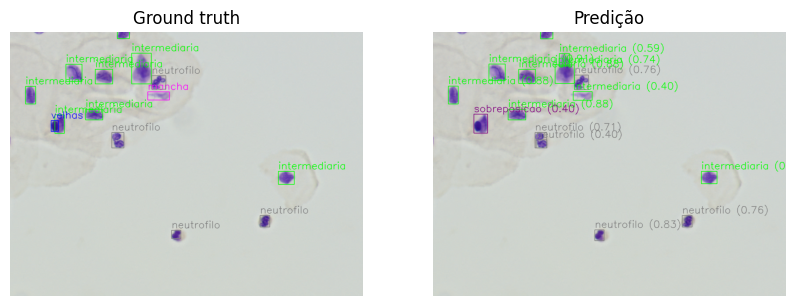

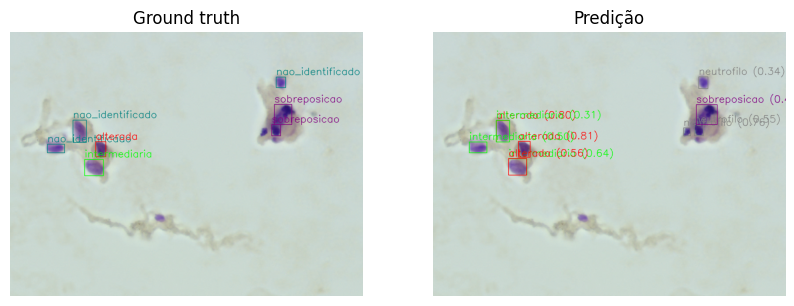

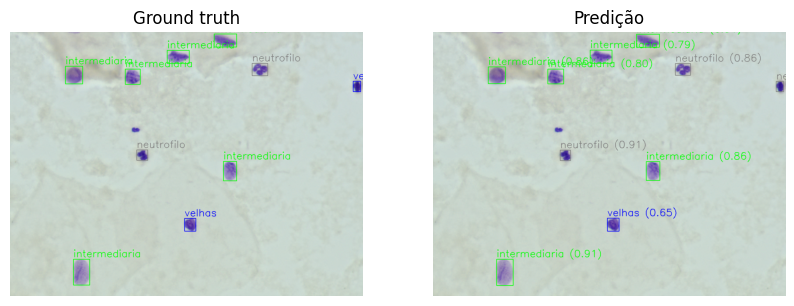

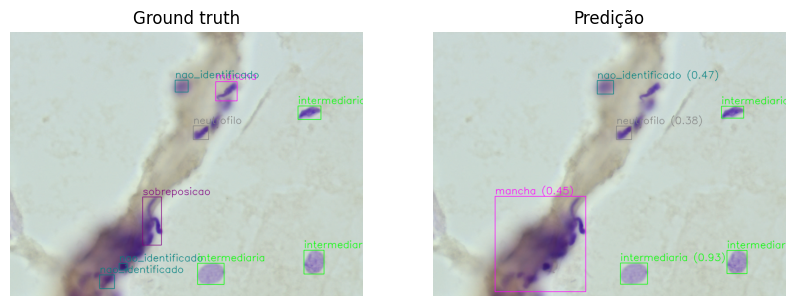

In [ ]:
for image_name in example_test_images:
  full_path = f"{DIR}/test/images/{image_name}.png"
  labels_path = f"{DIR}/test/labels/{image_name}.png"

  pred_boxes = [item for item in predictions if item['image_id'] == image_name and item['score'] > THRESHOLD]

  true_boxes = get_true_boxes(image_name)

  true_img = plot_image_with_boxes(full_path, true_boxes, labels_map, normalized=True, plot=False)
  pred_img = plot_image_with_boxes(full_path, pred_boxes, labels_map, normalized=False, plot=False)

  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(true_img)
  plt.title('Ground truth')
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(pred_img)
  plt.title('Predição')
  plt.axis('off')

  plt.savefig(f'predictions/{image_name}_pipeline_pred.png', bbox_inches='tight')
  plt.show()


# Extração de métricas com COCOeval, para comparação com abordagem clássica

In [ ]:
def convert_to_coco_format(image_dir, label_dir, output_file):
    coco_data = {
        "info": {},
        "licenses": [],
        "images": [],
        "annotations": [],
        "categories": []
    }

    categories = [{
        "id": value,
        "name": key,
        "supercategory": "none",

    } for key, value in CATEGORIES_DICT.items()
    ]

    coco_data["categories"] = categories

    annotation_id = 1

    for filename in os.listdir(image_dir):
        if filename.endswith(".png"):
            image_path = os.path.join(image_dir, filename)
            label_path = os.path.join(label_dir, filename.replace(".png", ".txt"))

            with Image.open(image_path) as img:
                width, height = img.size

            coco_data["images"].append({
                "id": filename.replace('.png',''),
                "file_name": filename,
                "width": width,
                "height": height,
            })

            with open(label_path, 'r') as label_file:
                csv_reader = csv.reader(label_file, delimiter=',')
                for bbox in csv_reader:
                    x, y, w, h, label = int(bbox[0].strip()), int(bbox[1].strip()), int(bbox[2].strip()), int(bbox[3].strip()), bbox[4].strip()

                    coco_data["annotations"].append({
                        "id": annotation_id,
                        "image_id": filename.replace('.png',''),
                        "category_id": CATEGORIES_DICT[label],
                        "bbox": [x, y, w, h],
                        "area": w * h,
                        "iscrowd": 0,
                    })

                    annotation_id += 1

    with open(output_file, 'w') as json_file:
        json.dump(coco_data, json_file)


In [ ]:
convert_to_coco_format("/content/OD_SS/train/Images/", "/content/OD_SS/train/OD_Labels/", "train_coco.json")
convert_to_coco_format("/content/OD_SS/val/Images/", "/content/OD_SS/val/OD_Labels/", "val_coco.json")
convert_to_coco_format("/content/OD_SS/test/Images/", "/content/OD_SS/test/OD_Labels/", "test_coco.json")

In [ ]:
coco_json_path = 'test_coco.json'

In [ ]:
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

gt_coco = COCO(coco_json_path)

pred_coco = gt_coco.loadRes("/content/runs/detect/train2/predictions.json")

coco_eval = COCOeval(gt_coco, pred_coco, 'bbox')

coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.09s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.27s).
Accumulating evaluation results...
DONE (t=0.42s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.495
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.645
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.557
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.174
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.467
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.622
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.232
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.673
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets